# DeutscheWelle Data Engineering Challenge

9.05.2023


# Task 1

## Connect via Gmail API



In [ ]:
## Script that dowloads emails from gmail inbox

## from https://developers.google.com/gmail/api/reference/rest/v1/users.messages.attachments/get 
# # Method to download email attachments from gmail api
##
# userId dwdechallenge@gmail.com / me (authenticated user)
# messageId 
# id  2022-09-15-23-04-08-EDT-Historical-Report-ENTRFacebook-2022-06-16--2022-09-16.csv 
#GET https://gmail.googleapis.com/gmail/v1/users/{userId}/messages/{messageId}/attachments/{id}

In [ ]:
from googleapiclient.discovery import build
from google.oauth2.credentials import Credentials
from googleapiclient.errors import HttpError
import base64
import os
import time
import sys 

# Import functions from source folder
sys.path.append('../src/') 
from api_functions import *


In [ ]:
# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
creds = Credentials.from_authorized_user_file('../token.json', SCOPES)
service = build('gmail', 'v1', credentials=creds)

## search for emails with 'report' in the attachment name
query_string='filename:report*csv' #find all the email with attachment in csv format containing 'report' in their name
# other possible queries
#query_string='report' # all email with report in subject/body text
#query_string='has:attachment' # all email with attachments
email_messages = search_email(service, query_string,['INBOX'])
try:
    path = os.path.join('../', 'data/downloaded')
    os.mkdir(path)
except OSError as error:
    print(error) 
save_location='../data/downloaded'
## download attachments for found emails 

for email_message in email_messages:
    #print(email_message['id'])
    #187ffb2fbf3c1bc5
    messageDetail = get_message_detail(service,email_message['id'],msg_format='full',metadata_headers=['parts'])
    #print(messageDetail)
    messageDetailPayload = messageDetail.get('payload')

    if 'parts' in messageDetailPayload:
        for msgPayload in messageDetailPayload['parts']:
            file_name = msgPayload['filename']
            body=msgPayload['body']

            if 'attachmentId' in body:
                attachment_id = body['attachmentId']
                attachment_content= get_file_data(service,email_message['id'],attachment_id,file_name,save_location)
                print(file_name)
                
                #with open(os.path.join(save_location + '/' 'Downloaded_files' + '/' + file_name),'wb') as _f:
                with open(os.path.join(save_location + '/' + file_name),'wb') as _f:
                    _f.write(attachment_content)
                    print(f'File {file_name} is saved at {save_location}')
    time.sleep(0.5)
    #break

## Read the data from the files and upload them to the postgres database.

In [28]:
import pandas as pd
import psycopg2
import os
import glob
import sys

# Import functions from source folder
sys.path.append('../src/') 
from postgres_functions import *

In [25]:
#downloaded report .csv files

daily_repo_filepath='../data/downloaded/' # downloaded files via API
files=glob.glob(os.path.join(daily_repo_filepath,"*.csv"))
files

['../data/downloaded/2022-09-18-23-03-32-EDT-Historical-Report-ENTRFacebook-2022-06-19--2022-09-19.csv',
 '../data/downloaded/2022-09-16-23-04-01-EDT-Historical-Report-ENTRFacebook-2022-06-17--2022-09-17.csv',
 '../data/downloaded/2022-09-21-23-04-26-EDT-Historical-Report-ENTRFacebook-2022-06-22--2022-09-22.csv',
 '../data/downloaded/2022-09-17-23-04-42-EDT-Historical-Report-ENTRFacebook-2022-06-18--2022-09-18.csv',
 '../data/downloaded/2022-09-20-23-03-35-EDT-Historical-Report-ENTRFacebook-2022-06-21--2022-09-21.csv',
 '../data/downloaded/2022-09-15-23-04-08-EDT-Historical-Report-ENTRFacebook-2022-06-16--2022-09-16.csv',
 '../data/downloaded/2022-09-23-23-04-15-EDT-Historical-Report-ENTRFacebook-2022-06-24--2022-09-24.csv']

In [ ]:
#check the data with pandas
data = pd.read_csv(files[0])
data.head()

In [26]:
# connect to postgres database
#parameters
param_dic = {
    "host"      : "localhost",
    "database"  : "postgres",
    "user"      : "postgres",
}

In [29]:
#create postgres database

# column names from pandas dataframe csv file
cols=','.join([column.replace(" ", "_").replace("?","").lower() + str(' VARCHAR') for column in data.columns.values])

#name of a new postgres database 
new_table='table103'

#query=("DROP TABLE IF EXISTS %s;"%(new_table))
query=("CREATE TABLE IF NOT EXISTS %s(%s)" %(new_table,(cols))) 

conn = connect(param_dic)
execute_query(conn, query)
#create_postgres(data,table)

#name of the postgres database to upload data
table=new_table

#upload data from csv files to postreg database
[upload_csv_to_postgres(table,files) for file in files]

Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful
Connecting to the PostgreSQL database...
Connection successful


[None, None, None, None, None, None, None]

In [ ]:
conn = connect(param_dic)
execute_query(conn, 'SELECT Page_Name User_Name FROM new_table')

In [30]:
##SQL script to process the data and push the data to GIT
## create tables 
path_preproc='/Users/anya/SCIENCE/DW_Challenge/data/processed/'
video_table=pd.read_csv(path_preproc+'video_statistics_table.csv')
video_table

,page_admin_top_country,video_share_status,total_views,video_length
0,Page Admin Top Country,Video Share Status,Total Views,Video Length
1,PL,crosspost,14,00:04:30
2,DE,owned,599,00:01:13
3,DE,owned,1498,00:05:04
4,PL,crosspost,243,00:05:23
...,...,...,...,...
346894,PL,crosspost,1659,02:01:30
346895,PL,crosspost,1299,02:01:30
346896,FR,crosspost,1122,00:12:29
346897,PL,crosspost,1263,00:04:08


In [54]:
video_table['video_share_status'].unique()

#remove Video Share Status from the rows
df = video_table.drop(video_table[video_table['video_share_status'] == 'Video Share Status'].index)
#remove nan values from dataframe
df_new = df.dropna(axis=0)

df_new.head()

,page_admin_top_country,video_share_status,total_views,video_length
1,PL,crosspost,14,00:04:30
2,DE,owned,599,00:01:13
3,DE,owned,1498,00:05:04
4,PL,crosspost,243,00:05:23
6,PL,crosspost,7138,00:05:00


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 346850 entries, 1 to 346898
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   page_admin_top_country  346850 non-null  object
 1   video_share_status      342790 non-null  object
 2   total_views             346850 non-null  object
 3   video_length            342790 non-null  object
dtypes: object(4)
memory usage: 13.2+ MB


In [57]:
df.describe()

,page_admin_top_country,video_share_status,total_views,video_length
count,346850,342790,346850,342790
unique,5,3,8170,1000
top,DE,crosspost,0,00:00:59
freq,128597,184660,4158,6755


In [58]:
df.isnull().sum()

page_admin_top_country       0
video_share_status        4060
total_views                  0
video_length              4060
dtype: int64

In [59]:
df['page_admin_top_country'].value_counts()

page_admin_top_country
DE    128597
FR    111937
PL     93205
PT     12327
RO       784
Name: count, dtype: int64

In [55]:
print(df_new['video_share_status'].unique())
print(df_new['page_admin_top_country'].unique())

['crosspost' 'owned' 'share']
['PL' 'DE' 'RO' 'FR' 'PT']


<Axes: xlabel='page_admin_top_country', ylabel='count'>

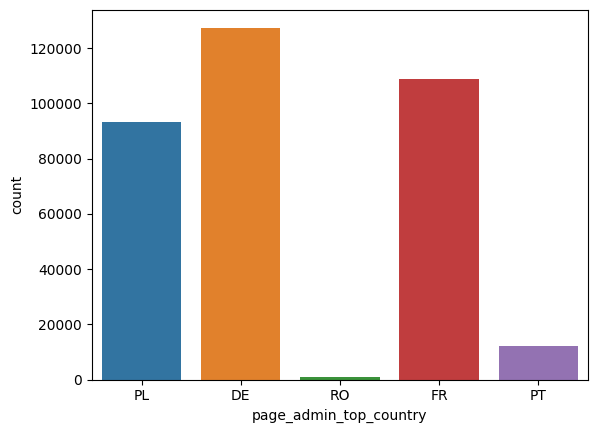

In [64]:
import seaborn as sns
# plot showing that most of the pages are created by admins from Germany
sns.countplot(x=df_new['page_admin_top_country'])

<Axes: xlabel='video_share_status', ylabel='count'>

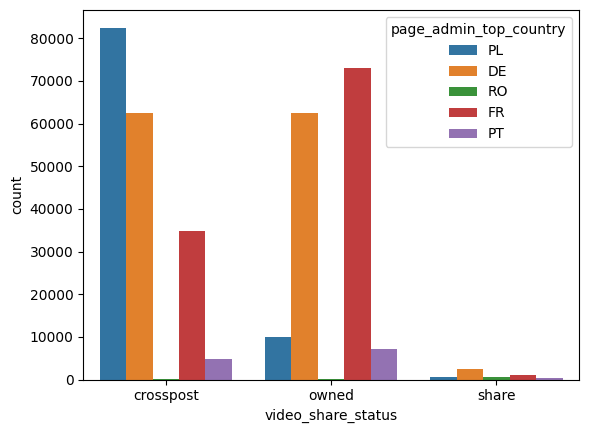

In [65]:
import seaborn as sns
# page admins in Poland tend to crosspost video content
# while french prefer to post their own video content
# german admins crosspost and share their own video content in equal proportions
# 
sns.countplot(hue=df_new['page_admin_top_country'],x=df_new['video_share_status'])

In [74]:
df_new['video_length'].description()

AttributeError: 'Series' object has no attribute 'description'

<Axes: xlabel='total_views', ylabel='Count'>

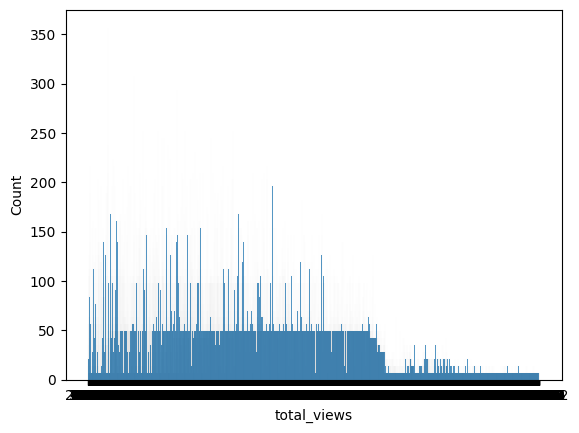

In [72]:
sns.histplot(df_new['total_views'],bins=df_new['video_length'])

In [ ]:
sns.scatterplot(data=df_new, x=df_new['total_views'],y=df_new['video_length'],hue=df_new['page_admin_top_country'])

# Task 2

#### Have a look at the dwh_dl_facebook_post_insights.csv. You will find there 3 rows for seperate posts. Import the csv to a database table

In [ ]:
# reading in the csv file
path_insights='/Users/anya/SCIENCE/DW_Challenge/data/external/Junior_DE_Task/'
db_insights=pd.read_csv(path_insights+'dwh_dl_facebook_post_insights.csv')
db_insights

In [ ]:
# creating a new postgres database
table='insights_draft'
data=db_insights
files_ins=glob.glob(os.path.join(path_insights,"*.csv"))
#conn = connect(param_dic)
create_postgres(data,table)
# uploading data from csv file to the new database
upload_csv_to_postgres(table,files_ins)

In [ ]:
cols_ins=cols=','.join([column.replace(" ", "_").replace("?","").lower() for column in data.columns.values])
cols_ins

In [ ]:
files_ins

### Please write a SQL script to unpack the json in column post_video_view_time_by_age_bucket_and_gender in a new table, while preserving the other columns.

In [ ]:
SELECT 
   id, 
   data::json->'name' as name,
   data::json->'author' ->> 'last_name' as author
FROM books;

In [ ]:
conn = connect(param_dic)

sel_column='post_video_view_time_by_age_bucket_and_gender'
table='insights_draft'
execute_query(conn,'SELECT %s FROM %s'%(sel_column,table))

In [ ]:
execute_query(conn,'SELECT %s FROM %s'%(sel_column,table))

In [ ]:
execute_query(conn, "SELECT %s  FROM %s, data::jsons->'U.18-24' as U.18-24, data::jsons->'U.25-34' as U.25-34"%(sel_column,table))

In [ ]:
execute_query(conn,'SELECT %s FROM %s, json_each(%s)'%(sel_column,table,sel_column))

In [ ]:
print(sel_column)
conn = connect(param_dic)
execute_query(conn, "SELECT %s json_data -> '%s' %s, FROM %s;" %(sel_column,sel_column,'foo',table))

In [ ]:
table

In [ ]:
conn = psycopg2.connect("host=localhost dbname=postgres user=postgres")
cur = conn.cursor()
cur.execute("""
    SELECT json_data 
        post_video_view_time_by_age_bucket_and_gender -> "U.18-24" as U1
    FROM insights_draft;
    """)
conn.commit()
conn.close()

In [ ]:
conn = psycopg2.connect("host=localhost dbname=postgres user=postgres")
cur = conn.cursor()
cur.execute("""
    SELECT (post_video_view_time_by_age_bucket_and_gender) from insights_draft;
    """)
conn.commit()
conn.close()

In [ ]:
execute_query(conn,'select jsonb_object_keys(%s) from %s;'%(sel_column,table))

In [ ]:
table

In [ ]:
print(sel_column)
conn = connect(param_dic)
execute_query(conn, "SELECT %s -> 'U.18-24' AS U1 FROM %s" %(sel_column,table))

#SELECT post_video_view_time_by_age_bucket_and_gender FROM insights_draft;

#SELECT post_video_view_time_by_age_bucket_and_gender json_data ->> 'U.18-24' AS U1 FROM insights_draft; 

In [ ]:
execute_query(conn,"select 
    json_data #> 
       '{pizzas,1,additionalToppings}'  
        as additional_toppings_2nd_pizza
from test;")

### Write a script for the sums per post for each gender. Additionally create the sum for age 18-34 of all genders.

In [ ]:
# SELECT SUM(Quantity) FROM OrderDetails;
# add where statement WHERE Country='Mexico' WHERE Country='Mexico'
# SELECT * FROM Products WHERE Price BETWEEN 50 AND 60;